In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge

In [2]:
#-----Import the Excel as Dataframe
p2 = pd.read_excel('UHF.xlsx')

In [3]:
#-----Create the feature vector
Conduct = p2['Conductivity uS/cm']
Conduct_V2 = Conduct[935:]
Conduct_V2.interpolate(inplace = True)
Water = p2['water flux mm/hr']
Water.interpolate(inplace = True)
pH = p2['pH']
pH.interpolate(inplace = True)

y1 = p2['Cl mg/l']
y = y1[935:]
y.interpolate(inplace = True)
y = y.to_numpy()

tx = np.zeros((len(Conduct_V2),3))
tx[:,0] = Conduct_V2
tx[:,1] = Water[935:]
tx[:,2] = pH[935:]

In [4]:
def calculate_loss(y, tx, w):
    """compute the cost by negative log likelihood."""
    pred = sigmoid(tx.dot(w))
    loss = y.T.dot(np.log(pred)) + (1 - y).T.dot(np.log(1 - pred))
    return np.squeeze(- loss)

In [5]:
def calculate_gradient(y, tx, w):
    """compute the gradient of loss."""
    pred = sigmoid(tx.dot(w))
    grad = tx.T.dot(pred - y)
    return grad

In [6]:
def learning_by_gradient_descent(y, tx, w, gamma):
    """
    Do one step of gradient descen using logistic regression.
    Return the loss and the updated w.
    """
    loss = calculate_loss(y, tx, w)
    grad = calculate_gradient(y, tx, w)
    w -= gamma * grad
    return loss, w


Implementation of the logistic regression

In [7]:
def logistic_regression(y, tx, initial_w, max_iters, gamma):
    if(initial_w is None):
        initial_w = np.zeros(tx.shape[1])
    # initialize parameters
    threshold = 1e-8
    losses = []
    w = initial_w
    # start the logistic regression
    for iter in range(max_iters):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, gamma)
        # converge criterion
        losses.append(loss)    
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    return w, loss

Implementation of the cross validation

In [8]:
def cross_validation(y, x, k_indices, k, regression_method, **args):
    msk_test = k_indices[k]
    msk_train = np.delete(k_indices, (k), axis=0).ravel()

    x_tr = x[msk_train, :]
    x_te = x[msk_test, :]
    y_tr = y[msk_train]
    y_te= y[msk_test]

    weights, loss = logistic_regression(y=y_tr, tx=x_tr, **args)
    return weights, loss

In [9]:
#----Compute the absolute mean difference between two arrays
def compute_diff(y_prime,y):
    ecart = 0
    for i in range(len(y_prime)):
        ecart += abs(y_prime[i]-y[i])
    mean = ecart /  len(y_prime)
    return mean   

In [ ]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

0.3482345836583704


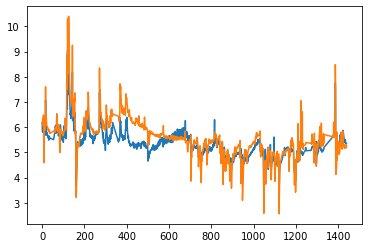

In [14]:
seed = 5
k_fold = 5
k_indices = build_k_indices(y, k_fold, seed)
K_indices = k_indices + 935

gamma = 0.0000000011
max_iters = 1000

accs_train = []
accs_test = []
diff = 0
weights = np.zeros(3)
for k in range(k_fold):
    weight, loss = cross_validation(y, tx, k_indices, k, logistic_regression, initial_w=None, max_iters=max_iters, gamma=gamma)
    weights += weight
    
    
y_prime = tx@(weights/k_fold)
plt.plot(y_prime)
plt.plot(y)
print(compute_diff(y_prime,y))

Implementation of the Ridge Regression

0.417470571995011


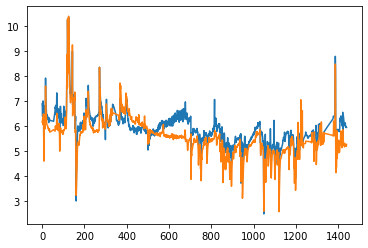

In [11]:
rr = Ridge(alpha = 0.1)
rr.fit(tx,y)
w = rr.coef_
y_prim = tx@w
plt.plot(y_prim)
plt.plot(y)
print(compute_diff(y_prim,y))